In [65]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

# Problem

In [43]:
def f(x):
    raise NotImplementedError

In [44]:
x_0 = torch.tensor([0, 0, 0, 0])  # initial point
N = x_0.shape[0]  # problem dimensionality

# Constants

In [45]:
I = torch.eye(N)

# Helper functions

In [24]:
def d_p(x, p):
    '''
    Prox-function
    '''
    return 1 / (p + 1) * x**(p + 1)


def gradient(f, x, create_graph=False, retain_graph=None):
    '''
    Gradient of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    '''
    Hessian of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def hessian_vector_product(f, x, v, retain_graph=False):
    '''
    Hessian-vector product: D^2(f) @ v
    '''
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [36]:
x = torch.tensor([1.5, 2.5], requires_grad=True)
e = torch.tensor([1., 1.])
f = x.pow(2).prod()
print('F =', f, '\n')

g = gradient(f, x, retain_graph=True)
print('g =', g, '\n')

h = hessian(f, x)
print('h =', h, '\n')

he = hessian_vector_product(f, x, e, retain_graph=True)
print('h @ e =', he, '\n')

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 



# Auxilary problem

In [130]:
def tridiag(d, e):
    '''
    Construct symmetric tridiagonal matrix from its main diagonal d and 
    above/below main diagonals equal to e
    '''
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    '''
    Decomposition of symmetric matrix A to U @ T @ U.T, where
    U - symmetric ortogonal matrix, T - symmetric tridiagonla matrix
    '''
    a = A.tolist()
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
    value = .5 * tau**2 + .5 * c_tilda.T @ torch.inverse(gamma * tau * I + T) @ c_tilda
    return -value


def solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate):
    tau = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    for i in range(1000):  # TODO
        value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
        value.backward()
        with torch.no_grad():
            tau -= learning_rate * tau.grad
        tau.grad.detach_()
        tau.grad.zero_()
    return tau


def solve_auxilary_problem(A, c, gamma):
    T, U = utu_decomposition(A)
    c_tilda = U.T @ c

    tau = solve_auxilary_subproblem(T, c_tilda, gamma, 0.1)
    h = -U @ torch.inverse(gamma * tau * I + T) @ c_tilda
    
    return h

A = tensor([[ 11.,  -7., -18., -25.],
        [ -7.,  29.,   0.,   8.],
        [-18.,   0.,  52.,  50.],
        [-25.,   8.,  50.,  69.]]) 

T = tensor([[ 24.3628, -11.5707,   0.0000,   0.0000],
        [-11.5707,   9.1451,  -4.7824,   0.0000],
        [  0.0000,  -4.7824,  58.4920, -56.4712],
        [  0.0000,   0.0000, -56.4712,  69.0000]]) 

U = tensor([[ 0.2656,  0.8564,  0.4427,  0.0000],
        [ 0.9639, -0.2256, -0.1417,  0.0000],
        [-0.0214,  0.4643, -0.8854,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[ 1.1000e+01, -7.0000e+00, -1.8000e+01, -2.5000e+01],
        [-7.0000e+00,  2.9000e+01,  0.0000e+00,  8.0000e+00],
        [-1.8000e+01,  2.3842e-07,  5.2000e+01,  5.0000e+01],
        [-2.5000e+01,  8.0000e+00,  5.0000e+01,  6.9000e+01]]) 

tau = tensor(nan, requires_grad=True) 



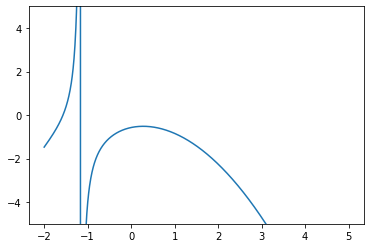

In [154]:
c = torch.randn(4)
x = torch.randn(4, requires_grad=True)
f = -torch.log(torch.sigmoid(x @ c))
A = hessian(f, x)
# A = torch.tensor([
#     [-1, -2, 1, 2],
#     [-2, 3, 0, -2],
#     [1, 0, 2, 1],
#     [2, -2, 1, 4]
# ], dtype=torch.float32)
A = torch.tensor([
    [1, -1, 0, -3],
    [-2, 5, 0, 0],
    [0, 0, 4, 6],
    [-4, 0, 2, 7]
], dtype=torch.float32)
A = A @ A.T
gamma = 1

T, U = utu_decomposition(A)
print('A =', A, '\n')
print('T =', T, '\n')
print('U =', U, '\n')
print('U @ T @ U.T =', U @ T @ U.T, '\n')

tau = solve_auxilary_subproblem(T, c, gamma, 0.1)
print('tau =', tau, '\n')

xx = np.linspace(-2, 5, 1000)
y = [auxilary_subproblem_objective(x, T, c, gamma) for x in xx]
plt.plot(xx, y)
plt.ylim(-5, 5)
plt.plot([tau, tau], [-5, 5])

# h = solve_auxilary_problem(A, c, gamma)
# print('h =', h, '\n')

In [151]:
torch.eig(A @ A.T)

torch.return_types.eig(
eigenvalues=tensor([[120.5555,   0.0000],
        [ 30.6963,   0.0000],
        [  1.1599,   0.0000],
        [  8.5883,   0.0000]]),
eigenvectors=tensor([]))

In [144]:
A

tensor([[ 0.0113, -0.0205, -0.0113,  0.0388],
        [-0.0205,  0.0370,  0.0205, -0.0702],
        [-0.0113,  0.0205,  0.0113, -0.0388],
        [ 0.0388, -0.0702, -0.0388,  0.1329]])

In [145]:
torch.sigmoid(x @ c)

tensor(0.1746, grad_fn=<SigmoidBackward>)

In [153]:
T

tensor([[ 24.3628, -11.5707,   0.0000,   0.0000],
        [-11.5707,   9.1451,  -4.7824,   0.0000],
        [  0.0000,  -4.7824,  58.4920, -56.4712],
        [  0.0000,   0.0000, -56.4712,  69.0000]])